In this sset of notebooks, I will be exploring different interpretation techniques. I will be using the CT images from the RICORD Database, which is for COVID-19 diagnoses. The images are in DICOM format. Set 1a is the positive diagnoses and set 1b is the negative diagnoses. 
This notebook will be exploring grad-CAM.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from random import shuffle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
import pydicom


Similar to what we did in our image conversion notebook, we will first make a list of all our PNG images

In [2]:
neg_dir='D:\\tensorflow_datasets\\covid-CT\\negative\\images'
pos_dir='D:\\tensorflow_datasets\\covid-CT\positive\\images'

# Get the list of all files in directory tree at given path
def buildList(directoryPath):
    listOfFiles = list()
    for (dirpath, dirnames, filenames) in os.walk(directoryPath):
        listOfFiles += [os.path.join(dirpath, file) for file in filenames]
    return listOfFiles

In [3]:
positive_files=buildList(pos_dir)
negative_files=buildList(neg_dir)

Now we can verify our data - it should look the same as in our conversion notebook

In [4]:
print('negative file example: ', negative_files[0])
print('positive file example: ', positive_files[0])
print('\n')
print('# of negative results: ', len(negative_files))
print('# of positive results: ', len(positive_files))
print('total images: ', len(negative_files)+len(positive_files))

print('positive:negative ratio: ', len(positive_files)/len(negative_files))

negative file example:  D:\tensorflow_datasets\covid-CT\negative\images\img0.png
positive file example:  D:\tensorflow_datasets\covid-CT\positive\images\img0.png


# of negative results:  21220
# of positive results:  31856
total images:  53076
positive:negative ratio:  1.501225259189444


Now let's read a single DICOM image to test, and output the image array that we will be using. We aren't going to be using the other info attached to the dicom images - we only want the images themselves. We can use pydicom to read the images, and with numpy installed we can convert the pixel array to an ndarray

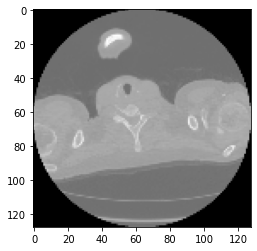

In [5]:
img=cv2.imread(negative_files[0])
plt.imshow(img)


In [6]:
def buildSet(fileList, label):
    i=0
    data_df=[]
    for f in fileList: 
        path = f
        img = cv2.imread(f)
        data_df.append([np.array(img), label, path])
        i+=1
    shuffle(data_df)
    return data_df

Now let's build our sets. This will take a while since we are reading all of the images 1-by-1

For now, we will use a small subset to make sure our code works, then run it again with the whole directory. 

In [7]:
class_info={0: 'COVID-negative', 1:'COVID-positive'}

positive_set = buildSet(positive_files,1)
negative_set = buildSet(negative_files,0)

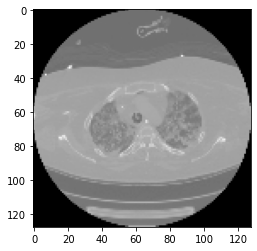

In [8]:
# make sure the images are still accessible - they are stored in a df so we need to acces the 
    #first element of the first array
plt.imshow(positive_set[0][0])

Now we should merge the positive and negative test images, and build our x_train and y_train set. 

In [9]:
xtrain_positives = np.array([i[0] for i in positive_set])
xtrain_negatives = np.array([i[0] for i in negative_set])
X = np.concatenate((xtrain_positives,xtrain_negatives))

ytrain_negatives= np.array([i[1] for i in negative_set])
ytrain_positives= np.array([i[1] for i in positive_set])
y = np.concatenate((ytrain_positives,ytrain_negatives))

In [10]:
y

array([1, 1, 1, ..., 0, 0, 0])

In [11]:
X.shape
#shape should be (nsamples,image_height,image_width,depth)

(53076, 128, 128, 3)

In [12]:
def make_model(input_shape):
    inputs = keras.Input(shape=input_shape)

    x = layers.Conv2D(filters=32, kernel_size=2, activation="relu")(inputs)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=64, kernel_size=2, activation="relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=128, kernel_size=2, activation="relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(filters=256, kernel_size=2, activation="relu")(x)
    x = layers.MaxPool2D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="2dcnn")
    return model

#use the shape from above here (last 3 values)
model = make_model(input_shape=(128,128,3))
model.summary()

Model: "2dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 127, 127, 32)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 63, 63, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 64)        256   

In [13]:
from sklearn.model_selection import train_test_split

val_split = 0.20
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_split, stratify=y)

X = np.concatenate((X_train, X_val))
y = np.concatenate((y_train, y_val))

In [14]:
from sklearn.model_selection import train_test_split

val_split = 0.20
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_split, stratify=y)

X = np.concatenate((X_train, X_val))
y = np.concatenate((y_train, y_val))

In [15]:
y_train.shape

(42460,)

In [17]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=val_split)

train_data = datagen.flow(X, y, subset = 'training')
val_data = datagen.flow(X,y,subset= 'validation')  


In [18]:
train_data

In [19]:
# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=["acc"],
)

# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "2d_image_classification.h5", save_best_only=True
)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
    
model.fit(train_data, validation_data=val_data, epochs=epochs,callbacks=[checkpoint_cb, early_stopping_cb])

'''model.fit(
    x=x_train,
    y=y_train,
    validation_split=0.10,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[checkpoint_cb, early_stopping_cb],
)'''


Epoch 1/100
1327/1327 [==============================] - 45s 28ms/step - loss: 0.4223 - acc: 0.8007 - val_loss: 0.3011 - val_acc: 0.8684
Epoch 2/100
1327/1327 [==============================] - 36s 27ms/step - loss: 0.1782 - acc: 0.9348 - val_loss: 0.1088 - val_acc: 0.9670
Epoch 3/100
1327/1327 [==============================] - 36s 27ms/step - loss: 0.0730 - acc: 0.9781 - val_loss: 0.1023 - val_acc: 0.9554
Epoch 4/100
1327/1327 [==============================] - 37s 28ms/step - loss: 0.0391 - acc: 0.9886 - val_loss: 0.1061 - val_acc: 0.9556
Epoch 5/100
1327/1327 [==============================] - 37s 28ms/step - loss: 0.0255 - acc: 0.9928 - val_loss: 0.0360 - val_acc: 0.9866
Epoch 6/100
1327/1327 [==============================] - 36s 27ms/step - loss: 0.0154 - acc: 0.9958 - val_loss: 0.0101 - val_acc: 0.9976
Epoch 7/100
1327/1327 [==============================] - 37s 28ms/step - loss: 0.0143 - acc: 0.9956 - val_loss: 0.0055 - val_acc: 0.9982
Epoch 8/100
1327/1327 [==================

1327/1327 [==============================] - 37s 28ms/step - loss: 0.0014 - acc: 0.9995 - val_loss: 2.6072e-04 - val_acc: 0.9999
Epoch 60/100
1327/1327 [==============================] - 36s 27ms/step - loss: 3.2987e-04 - acc: 0.9999 - val_loss: 2.5820e-04 - val_acc: 0.9999
Epoch 61/100
1327/1327 [==============================] - 37s 28ms/step - loss: 2.2960e-04 - acc: 1.0000 - val_loss: 9.3553e-04 - val_acc: 0.9997
Epoch 62/100
1327/1327 [==============================] - 36s 27ms/step - loss: 0.0020 - acc: 0.9993 - val_loss: 7.8349e-05 - val_acc: 1.0000
Epoch 63/100
1327/1327 [==============================] - 37s 28ms/step - loss: 5.9064e-04 - acc: 0.9998 - val_loss: 2.8825e-04 - val_acc: 1.0000


'model.fit(\n    x=x_train,\n    y=y_train,\n    validation_split=0.10,\n    epochs=epochs,\n    shuffle=True,\n    verbose=2,\n    callbacks=[checkpoint_cb, early_stopping_cb],\n)'

1


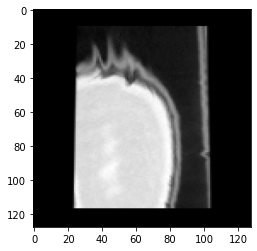

In [46]:
img = X[0]
print(y[0])
plt.imshow(img)

1
0


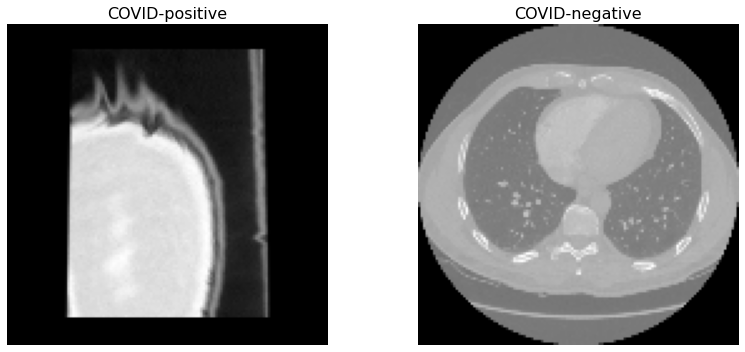

In [47]:
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tensorflow.keras.applications.vgg16 import preprocess_input




img1=X[0]
print(y[0])
img2=X[1]
print(y[1])

images = np.asarray([img1, img2])

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
for i, title in enumerate(images):
    ax[i].set_title(class_info[y[i]], fontsize=16)
    ax[i].imshow(images[i],cmap='gray')
    ax[i].axis('off')
plt.tight_layout()
plt.show()


In [48]:
images.shape

(2, 128, 128, 3)

In [49]:
def decode_prediction(pred):
  # This function thresholds a probability to produce a prediction
    pred = tf.where(pred < 0.5, 0, 1)
    return pred.numpy()

img = X[0]
label = y[0]

pred_raw = model.predict(np.expand_dims(img, axis=0))[0][0]

pred = decode_prediction(pred_raw)
pred_label = class_info[pred]

print('true label: ',label, '\n', 'Prediction: ', pred_label, pred_raw)


true label:  1 
 Prediction:  COVID-positive 1.0


In [50]:
from tensorflow.keras.models import Model

def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model
    

    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str


    Returns 
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = Model(
            inputs=[model.inputs],
            outputs=[model.get_layer(layer_name).output,
                model.output])
    
    with tf.GradientTape() as tape:
# cast the image tensor to a float-32 data type, pass the
# image through the gradient model, and grab the loss
# associated with the specific class index
        inputs = tf.cast(img_array, tf.float32)
        (convOutputs, predictions) = gradModel(inputs)
        loss = predictions[:, 0]
# use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
# the convolution and guided gradients have a batch dimension
# (which we don't need) so let's grab the volume itself and
# discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
# as weights, compute the ponderation of the filters with
# respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize
# the output class activation map to match the input image
# dimensions
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
# normalize the heatmap such that all values lie in the range
# [0, 1], scale the resulting values to the range [0, 255],
# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8")
# return the resulting heatmap to the calling function
    return heatmap


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):
    
    '''
    Superimposes a grad-cam heatmap onto an image for model interpretation and visualization.
    

    Args:
      image: (img_width x img_height x 3) numpy array
      grad-cam heatmap: (img_width x img_width) numpy array
      threshold: float
      emphasize: boolean

    Returns 
      uint8 numpy array with shape (img_height, img_width, 3)

    '''
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

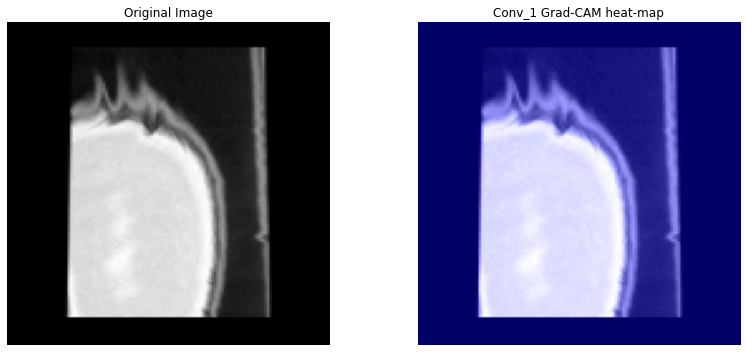

In [88]:
layer_name = 'conv2d_2'
img = X[0]
label = y[0]

grad_cam=GradCam(model,np.expand_dims(img, axis=0),layer_name)
grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=True)


plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(img,)
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Conv_1 Grad-CAM heat-map')
plt.tight_layout()

It seems like everything in this image & layer is evenly weighted. Let's look at the next one

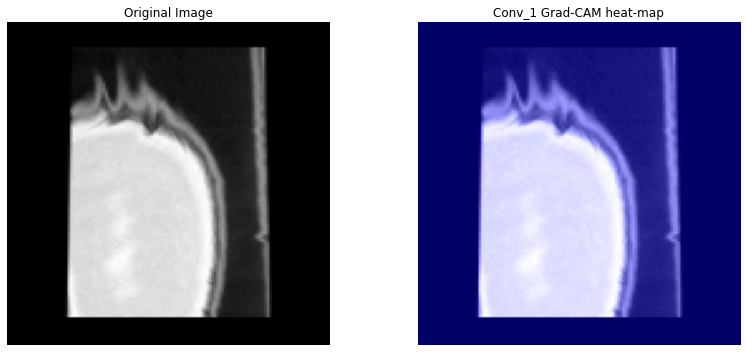

In [89]:
layer_name = 'conv2d_3'
img = X[0]
label = y[0]

grad_cam=GradCam(model,np.expand_dims(img, axis=0),layer_name)
grad_cam_superimposed = superimpose(img, grad_cam, 0.5, emphasize=True)


plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(img,)
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Conv_1 Grad-CAM heat-map')
plt.tight_layout()

It still seems to be evenly looking at the image. Let's look at all the layers now.

In [34]:
conv2D_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.Conv2D)]
conv2D_layers

['conv2d_3', 'conv2d_2', 'conv2d_1', 'conv2d']

In [35]:
activation_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.Conv2D)]
activation_layers

['conv2d_3', 'conv2d_2', 'conv2d_1', 'conv2d']

In [36]:
all_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4]
all_layers

['batch_normalization_3',
 'max_pooling2d_3',
 'conv2d_3',
 'batch_normalization_2',
 'max_pooling2d_2',
 'conv2d_2',
 'batch_normalization_1',
 'max_pooling2d_1',
 'conv2d_1',
 'batch_normalization',
 'max_pooling2d',
 'conv2d']

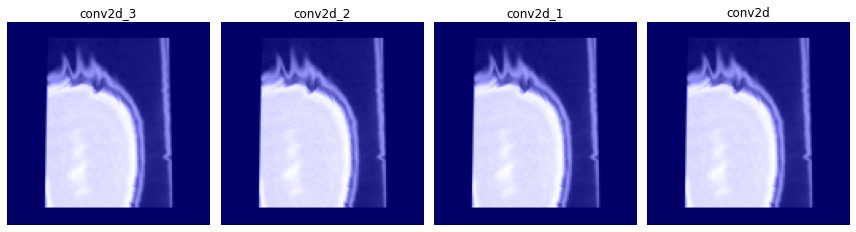

In [90]:
img = X[0]


plt.figure(figsize=(12,12))
for i, layer in enumerate(activation_layers):
    grad_cam = GradCam(model, np.expand_dims(img, axis=0), layer)
    grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=False)
    ax = plt.subplot(1,4, i +1)
    plt.imshow(grad_cam_emphasized)
    plt.title(layer)
    plt.axis("off")
plt.tight_layout()


These are some pretty interesting results! But here I've only included the convolution layers. So, lets look at ALL of the layers (that are valid)

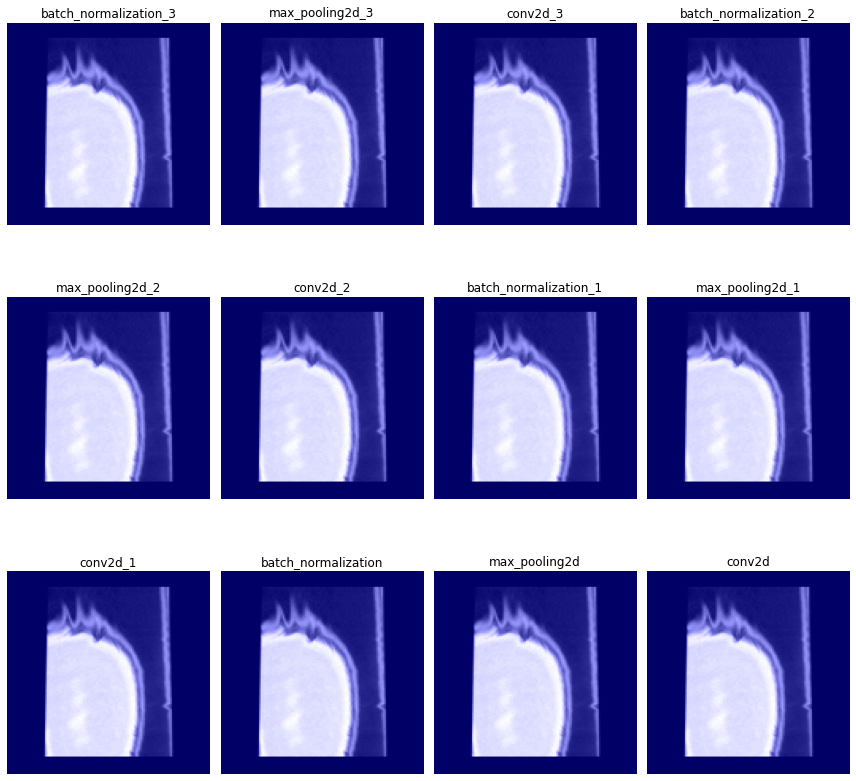

In [91]:
img = X[0]


plt.figure(figsize=(12, 12))
for i, layer in enumerate(all_layers):
    grad_cam = GradCam(model, np.expand_dims(img, axis=0), layer)
    grad_cam_emphasized = superimpose(img, grad_cam, 0.5, emphasize=False)
    ax = plt.subplot(3, 4, i +1)
    plt.imshow(grad_cam_emphasized)
    plt.title(layer)
    plt.axis("off")
plt.tight_layout()

These are some interesting results. Since there is no specific heatmap activity, we might be led to believe that the model is overfitting to our training data. And, with the 100% validation, we probably should be suspicious of our model. I discuss this more at the bottom of the notebook.

Let's look at another sample

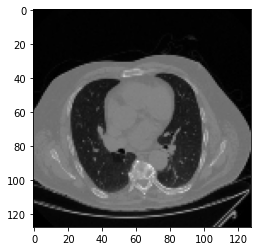

In [39]:
img2=X[201]
plt.imshow(img2)

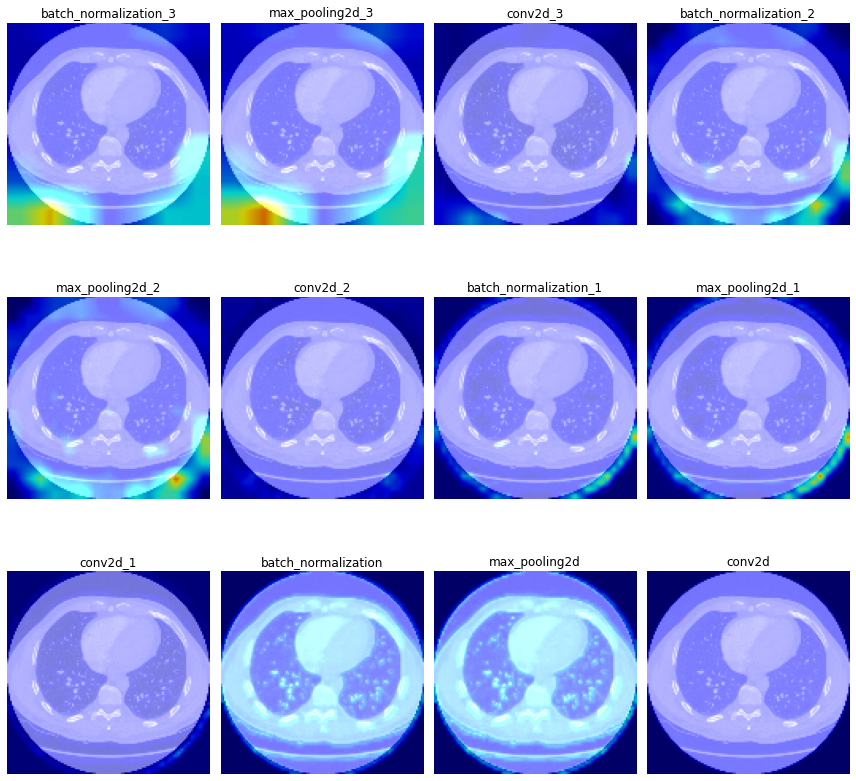

In [64]:
plt.figure(figsize=(12, 12))
for i, layer in enumerate(all_layers):
    grad_cam = GradCam(model, np.expand_dims(img2, axis=0), layer)
    grad_cam_emphasized = superimpose(img2, grad_cam, 0.5, emphasize=False)
    ax = plt.subplot(3, 4, i +1)
    plt.imshow(grad_cam_emphasized)
    plt.title(layer)
    plt.axis("off")
plt.tight_layout()

In [41]:
y[201]

0

In this second image/sample I've chosen, we can see that there are some features that are highlighted. Again, it looks like the model is recognizing which type of CT (supine/prone vs upright) by detecting the image borders. We can see in the batch_norm and max pooling on the bottom row that some features are being detected. The bright spots in the lungs tell us that the model is recognizing some important features related to COVID (lesioning/scar tissue).

Lastly, lets create a fused grad-cam for all of the layers combined

In [81]:
'''  
Fuses grad-cam heatmaps from a list of model layers into a single heatmap
and superimposes the heatmap onto an image.

Args:
  layers: list of strings
  model: tf model
  img: (img_width x img_height x 3) numpy array


Returns 
  uint8 numpy array with shape (img_height, img_width, 3)

'''
def fuse_layers(layers, model, img, emphasize=False):
    cams = []
    for layer in layers:
        cam = GradCam(model, np.expand_dims(img, axis=0), layer)
        cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
        cams.append(cam)

    fused = np.mean(cams, axis=0)
    superimposed = superimpose(img, fused, 0.5, emphasize=emphasize)

    return superimposed

In [82]:
fused = fuse_layers(all_layers, model, img, True)

Text(0.5, 1.0, 'All layers Grad-CAM heat-map')

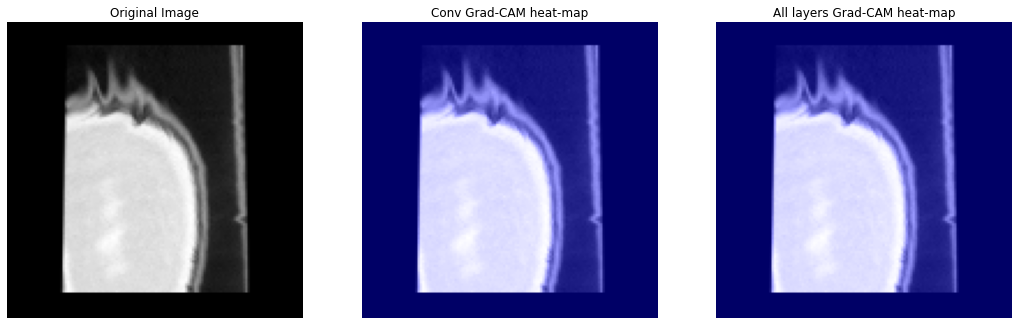

In [93]:
plt.figure(figsize=(18, 8))
ax = plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')

ax = plt.subplot(1, 3, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Conv Grad-CAM heat-map')
ax = plt.subplot(1, 3, 3)
plt.imshow(fused)
plt.axis('off')
plt.title('All layers Grad-CAM heat-map')

Text(0.5, 1.0, 'All layers Grad-CAM heat-map')

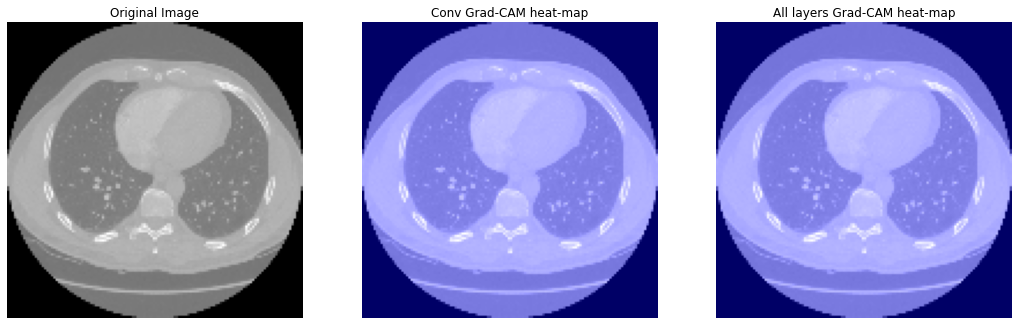

In [94]:
grad_cam2=GradCam(model,np.expand_dims(img2, axis=0),layer_name)
grad_cam_superimposed2 = superimpose(img2, grad_cam2, 0.5, emphasize=True)
fused2 = fuse_layers(all_layers, model, img2, True)

plt.figure(figsize=(18, 8))
ax = plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')

ax = plt.subplot(1, 3, 2)
plt.imshow(grad_cam_superimposed2)
plt.axis('off')
plt.title('Conv Grad-CAM heat-map')
ax = plt.subplot(1, 3, 3)
plt.imshow(fused2)
plt.axis('off')
plt.title('All layers Grad-CAM heat-map')

The first image for the two sets above is the original, followed by a single convolutional layer (the last one), followed by the combined. So it seems like overall, the model is having trouble recognizing features. Since many CT pictures are 'slices' from a single person, there are going to be pictures in the validation set that are from the same patient as the training set. This is why our validation accuracy is so high. For a set such as this, there needs to be manual separation of training and validation sets. 
I did not spend the time to do this mostly because that was not the goal of this set of noteboooks. I wanted to learn how to implement interpretation methods, specifically gradCAM, as opposed to spending time tuning a perfect model. I believe I accomplished my primary goal in these regards.

So, in the future, I'd like to work on some specific areas for tuning this model. Ideally, these CT slices would be first fed into layers to reconstruct them into 3D, and then fed into a 3D cnn (with proper test/validation split). Then I could spend time tuning the layers and hyperparameters to improve my results. 